# Text To Emotion

### Bài toán
- Phân loại văn bản theo 4 loại cảm xúc cơ bản (neutral, happy, angry, sad).

### Mục tiêu
- Tìm hiểu được cách crawl văn bản từ Google API.
- Tìm hiểu được cách preprocessing văn bản.
- Tìm hiểu được các cách biến đổi từ văn bản thành vector.
- Tìm hiểu được và xây dựng một nền tảng để có thể phân loại được cảm xúc khi nhập vào một đoạn văn bản.
- Tìm hiểu thêm được framework keras cũng như các hướng tiếp cận khác của bài toán.

### Ứng dụng
- Hiểu được cảm xúc của người dùng thông qua các dòng bình luận, nhận xét, đánh giá.
- Từ đó, có thể ứng dụng vào phân loại các cảm xúc của các comment từ đó rút ra thống kê, có thể ứng dụng vào trong các ứng dụng như: phân loại comment đánh giá sản phẩm (e-commerce), phân loại comment đánh giá trên facebook post, xếp loại video youtube bằng cách phân loại comment.
- Ứng dụng để gợi ý emoji trong các loại ứng dụng chat.

### Crawl dữ liệu
#### API
- Sử dụng GoogleAPIs crawl comment từ các video youtube, mỗi url video đa số chứa những comment thuộc cùng một nhóm. Ví dụ: video về nền công nghiệp gà, bò, hay chiến tranh thì đa số là angry, cũng có sad, các video âm nhạc giải trí mang tính thư giãn thì happy, những video của các vlogger thì đa phần là hỗn tạp vì có người thích và có người ghét.
    1. WjNFGZLJLss (angry)
    2. 5xzGjW_MEms (sad)
    3. nKDgFCojiT8 (sad)
    4. hEH7KgQY380 (happy)
    5. kIF3BYBXZWA (happy)
    6. NvZtkt9973A (happy)
    7. SuYwm-wBwBY (happy)
    8. iqmO1RlqorU (happy)
    9. 9ca8ThA83fE (happy)
    10. V-RwqjtQmm8 (angry)
    11. WuLZ9ZMA_FA (angry)
    12. kopI4-ebPxQ (prank)
    13. LEBtUTAf8uE (prank)
    14. eBSr1oiIDuU (prank)
    15. UYJl7z38V88 (prank)

#### Thông tin dữ liệu crawl
- Dữ liệu ở đây lên đến ~35k comment.
- Thông tin dữ liệu crawl chỉ là những comment, reply, không có label.
- Dẫn đến việc nhóm phải tự annotation lại dữ liệu bằng tay.

#### Annotation
- Nhóm có tự tạo file annotation.py để hỗ trợ việc annotate nhanh hơn và lưu lại cache để ghi nhớ những comment chưa annotate.
- Dữ liệu sau khi nhóm tự annotate vào khoảng ~12k comment.
- Các file dữ liệu dùng để anotate bao gồm:
    - encoded_angry.txt
    - encoded_happy.txt
    - encoded_sad.txt
    - encoded_prank.txt
- Nhóm sử dụng file script anotate để tạo thuận tiện cho việc anotate hơn.
- Kết quả sau khi anotate là các file:
    - final_angry.csv
    - final_happy.csv
    - final_sad.csv
    - final_prank.csv

In [1]:
from time import time
import string
import os
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

import codecs
import json
import re
import collections
import pandas as pd
import numpy as np

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

%matplotlib inline

In [2]:
f = codecs.open("./glove.6B.50d.txt","r","utf-8")
lines = f.readlines()
words = [x.split(' ')[0] for x in lines]
glove_dict = {}
for word in words:
    glove_dict[word] = word
f.close()
# Mở file đang làm dang dở trước đó (nếu có)
glove_dict.update(json.loads(open('dictionary.txt', "r").read()))

- Đầu tiên ta sẽ đọc data đã crawl từ 4 file *final_happy.csv*, *final_angry.csv*, *final_sad.csv*, *final_prank.csv*
- Vì đọc các file theo thứ tự nên data sẽ theo được sort theo trình tự happy -> angry -> sad -> prank. Nên ta sẽ shuffle lại data bằng hàm `df.reindex` kết hợp với `np.random.permutation`.
- Tiếp tục ta sẽ đổi header cho dễ đọc, dễ xử lý.

In [3]:
# Load các file csv vào thành 1 DataFrame
happy_train = pd.read_csv('./CrawlComment/final_happy.csv', sep='\t', header=None)
angry_train = pd.read_csv('./CrawlComment/final_angry.csv', sep='\t', header=None)
sad_train = pd.read_csv('./CrawlComment/final_sad.csv', sep='\t', header=None)
prank_train = pd.read_csv('./CrawlComment/final_prank.csv', sep='\t', header=None)
frames = [happy_train, angry_train, sad_train, prank_train]
df = pd.concat(frames, ignore_index=True)
df.info()

df = df.reindex(np.random.permutation(df.index))
df = df.rename(columns={0: "text", 1: "emotion"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12864 entries, 0 to 12863
Data columns (total 2 columns):
0    12864 non-null object
1    12864 non-null int64
dtypes: int64(1), object(1)
memory usage: 201.1+ KB


## 1. Observation and Preprocessing data

- Để biết được phân phối của dataset có đều nhau hay không hay nói cách khác là số lượng các emotion có đều nhau hay không, ta sẽ plot và sinh ra thêm một cột là emotion_label để visualize.
- Kết quả cho thấy Sad có số lượng lớn nhất, sau đó đến Neutral, Happy và cuối cùng là Angry.

| Emotion      | Emotion Label |
| :------------: | :-------------: |
| 0            | Neutral       |
| 1            | Happy         |
| 2            | Angry         |
| 3            | Sad           |

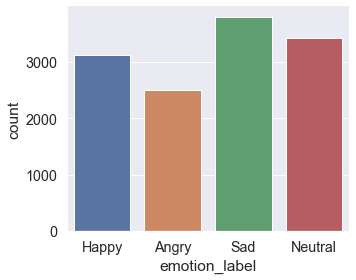

In [4]:
mapping = {
    3: 'Sad',
    0: 'Neutral',
    1: 'Happy',
    2: 'Angry'
}

def mappingToEmotion(value):
    return mapping[value]

df['emotion_label'] = df['emotion'].apply(mappingToEmotion) 
target_dist = sns.catplot(x="emotion_label", data=df, kind="count", height=4, aspect=1.2)
plt.show();

Ta xây dựng một lớp `Counting` để rút ra các features từ các sentences:
1. count_words: Số lượng từ trong một câu.
2. count_capital: Số lượng từ mà viết hoa trong một câu.
3. count_excl_quest: Số lượng dấu chấm hỏi và dấu chấm than.
4. count_positive_emojis: Số lượng emojis tích cực.
5. count_negative_emojis: Số lượng emojis tiêu cực.

In [5]:
class Counting(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, sentence):
        return len(re.findall(pattern, sentence))
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        count_words = X['text'].apply(lambda x: self.count_regex(r'\w+', x)) 
        count_capital = X['text'].apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest = X['text'].apply(lambda x: self.count_regex(r'!|\?', x))
        count_positive_emojis = X['text'].apply(lambda x: self.count_regex(r'[:=x][)D]', x))
        count_negative_emojis = X['text'].apply(lambda x: self.count_regex(r'[:]\'?[(]', x))
        
        df = X.copy()
        df['count_words'] = count_words
        df['count_capital'] = count_capital
        df['count_excl_quest'] = count_excl_quest
        df['count_positive_emojis'] = count_positive_emojis
        df['count_negative_emojis'] = count_negative_emojis
        
        return df

In [6]:
tc = Counting()
df_counts = tc.fit_transform(df)
df_counts['emotion_label'] = df['emotion_label']
df_counts['emotion'] = df['emotion']

In [7]:
def plt_hist(df, col, max_bin=None):
    if max_bin == None:
        max_bin = df[col].max() + 1
    print('Mô tả cho cột {}'.format(col))
    print()
    print(df.groupby('emotion_label')[col].describe())
    bins = np.arange(df[col].min(), max_bin)
    g = sns.FacetGrid(df, col='emotion_label', height=5, hue='emotion_label')
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Mô tả cho cột count_words

                count       mean        std  min  25%  50%   75%    max
emotion_label                                                          
Angry          2502.0  13.331735  17.268034  0.0  5.0  8.0  15.0  272.0
Happy          3128.0   9.584399  14.001390  0.0  3.0  6.0  11.0  372.0
Neutral        3436.0  10.584109  15.369232  0.0  5.0  8.0  12.0  501.0
Sad            3798.0  12.285677  16.344083  0.0  5.0  8.0  14.0  288.0


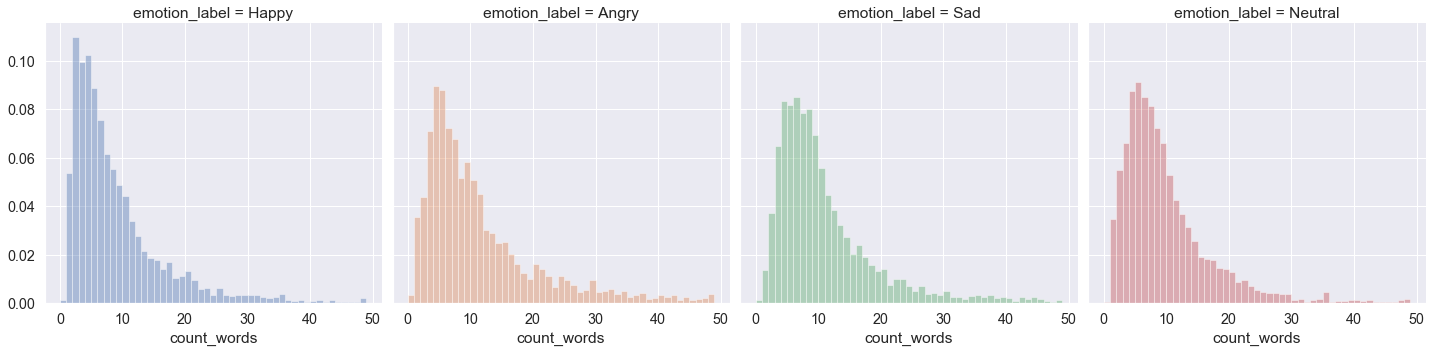

In [8]:
plt_hist(df_counts, col='count_words', max_bin=50)

Mô tả cho cột count_positive_emojis

                count      mean       std  min  25%  50%  75%   max
emotion_label                                                      
Angry          2502.0  0.003197  0.056467  0.0  0.0  0.0  0.0   1.0
Happy          3128.0  0.073210  0.351449  0.0  0.0  0.0  0.0  11.0
Neutral        3436.0  0.004366  0.065937  0.0  0.0  0.0  0.0   1.0
Sad            3798.0  0.003686  0.064809  0.0  0.0  0.0  0.0   2.0


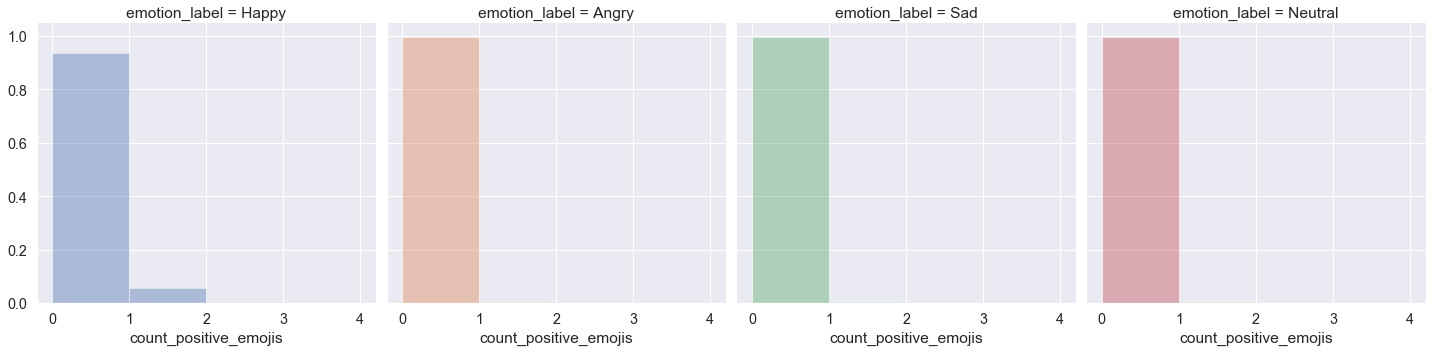

In [9]:
plt_hist(df_counts, col='count_positive_emojis', max_bin=5)

Mô tả cho cột count_negative_emojis

                count      mean       std  min  25%  50%  75%  max
emotion_label                                                     
Angry          2502.0  0.000799  0.028267  0.0  0.0  0.0  0.0  1.0
Happy          3128.0  0.000320  0.017880  0.0  0.0  0.0  0.0  1.0
Neutral        3436.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Sad            3798.0  0.017378  0.138517  0.0  0.0  0.0  0.0  3.0


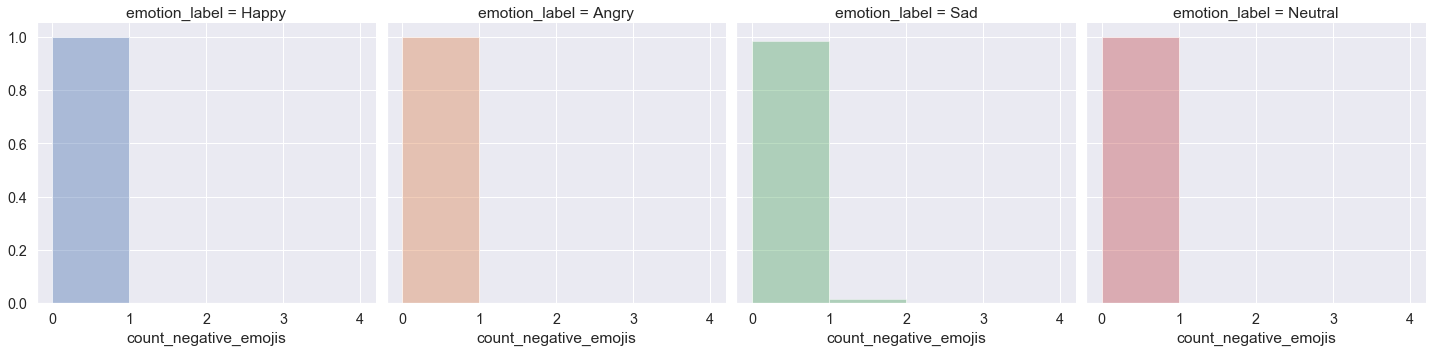

In [10]:
plt_hist(df_counts, col='count_negative_emojis', max_bin=5)

Mô tả cho cột count_excl_quest

                count      mean       std  min  25%  50%  75%   max
emotion_label                                                      
Angry          2502.0  0.578737  2.812265  0.0  0.0  0.0  0.0  82.0
Happy          3128.0  0.510230  1.992123  0.0  0.0  0.0  0.0  64.0
Neutral        3436.0  0.304715  0.913104  0.0  0.0  0.0  0.0  12.0
Sad            3798.0  0.291732  1.125840  0.0  0.0  0.0  0.0  36.0


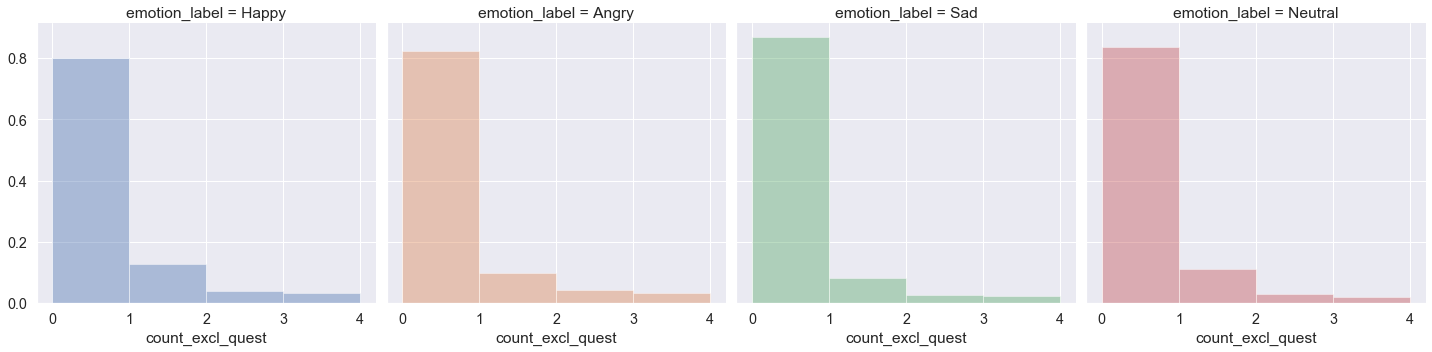

In [11]:
plt_hist(df_counts, col='count_excl_quest', max_bin=5)

Mô tả cho cột count_capital

                count      mean       std  min  25%  50%  75%    max
emotion_label                                                       
Angry          2502.0  0.757394  4.060800  0.0  0.0  0.0  0.0  110.0
Happy          3128.0  0.270460  1.530961  0.0  0.0  0.0  0.0   35.0
Neutral        3436.0  0.336438  1.645697  0.0  0.0  0.0  0.0   40.0
Sad            3798.0  0.406793  2.340993  0.0  0.0  0.0  0.0   97.0


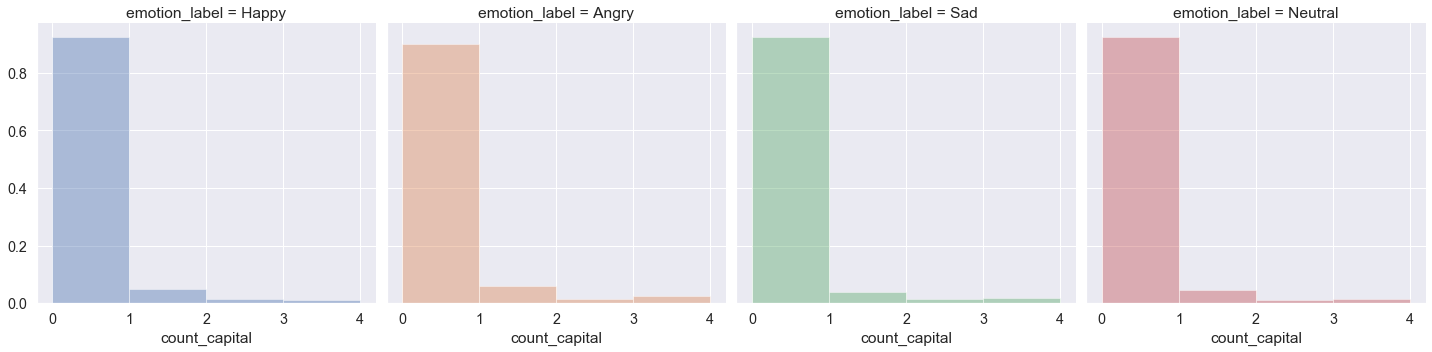

In [12]:
plt_hist(df_counts, col='count_capital', max_bin=5)

### Nhận xét
- `count_words`: Ta có thể thấy, những câu angry thường có số lượng từ nhiều hơn.
- `count_positive_emojis`: Đúng như nhóm dự đoán, những emoji tích cực sẽ tập trung ở label happy nhiều nhất, nhưng ở mỗi câu thì sẽ không chắc có emoji nên ở happy `mean` = 0.073
- `count_negative_emojis`: Tương tự như positive emojis, negative emoji sẽ tập trung ở sad nhiều nhất, `mean` = 0.017
- `count_excl_quest` và `count_capital`: Số lượng dấu chấm hỏi, dấu chấm than, và số lượng từ được in hoa sẽ xuất hiện nhiều nhất hơn emotion angry.

Nhóm sẽ quyết định giữ lại 5 thuộc tính này cho việc prediction.

### Clean the sentence

Sau khi có nhiều góc nhìn về dữ liệu và extract được 5 feature ở trên. Nhóm quyết định sử dụng tư tưởng Bag Of Word (BOW) để áp dụng vào field `text`. Nhưng với field `text` hiện tại có những bất cập:
   - Kí tự đặc biệt, số,...
   - Viết tắt: "omg", "asap", "tbh", ...
   - Viết sai chính tả
   - Viết nhảm (spam)
   - Có tên người
   - ...

Các bước chuẩn bị dữ liệu:
- Chuyển tất cả thành chữ thường
- Chỉ giữa các kí tự, xóa các kí tự đặc biệt và số, xóa các dòng text là rỗng
- Chuyển những từ sai chính tả thành những từ map với `glove_dict`, nếu từ đó không có trong `glove_dict`, nhóm sẽ nhập tay.
- Xóa tất cả các stop words dựa vào thư viện `nltk.corpus`.

In [13]:
class MakeCleanText(BaseEstimator, TransformerMixin):
    def normalize(self, x):
        try:
            x = x.lower().strip()
        except:
            return ''
        ans = ''
        for i in x:
            if 'a' <= i <= 'z' or i == ' ':
                ans += i
        return ans
    
    def keep_clean(self, sentence):
        sentence = sentence.strip()
        return ' '.join(sentence.split())
    
    def only_keep_alphabets(self, sentence):
        return self.normalize(sentence)
    
    def remove_spaces(self, sentence):
        return self.keep_clean(sentence)
    
    def translate_unknow_word(self, sentence):
        new_line = ''
        for word in sentence.split():
            if word not in glove_dict:
                print(word)
                glove_dict[word] = input(word + ' ')
                open("dictionary.txt", "w").write(json.dumps(glove_dict))
            else:
                new_line += ' ' + glove_dict[word]

        return new_line
    
    def remove_stop_word(self, sentence):
        stopwords_list = stopwords.words('english')
        words = sentence.split()
        keep_words = ['no']
        clean_words = [word for word in words if (word not in stopwords_list or word in keep_words) and len(word) > 1]
        return " ".join(clean_words)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_new = X.copy()
        
        clean_texts = X_new['text'].apply(self.only_keep_alphabets).apply(self.translate_unknow_word).apply(self.only_keep_alphabets).apply(self.remove_spaces).apply(self.remove_stop_word)
        
        X_new['clean_text'] = clean_texts
        
        return X_new

class FilterEmptyText(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(X[X.clean_text == ''].index)

Vì sau khi đã bỏ stop word nên sẽ có vài sentences không có từ nào trong câu. Trong pipeline nhóm đã thêm một class FilterEmptyText để lọc bỏ tất cả những câu rỗng. Sau đó transform dữ liệu và lưu trong field `clean_text` của df.

In [14]:
preprocess = Pipeline([
    ('mkclean', MakeCleanText()),
    ('rmempty', FilterEmptyText())
])

preprocess_df = preprocess.fit_transform(df)

In [15]:
preprocess_df.head()

,text,emotion,emotion_label,clean_text
8227,I learned my lesson,1,Happy,learned lesson
7274,If anyone is alone like me the hit the like,2,Angry,anyone alone like hit like
9663,"Such a cute couple, I do the same thing with m...",2,Angry,cute couple thing boyfriend ignores lol know s...
6800,that really make my heart cry,3,Sad,really make heart cry
12099,I was watching porn,0,Neutral,watching porn


Để có cái nhìn rõ hơn về tần suất xuất hiện của các từ trong dataset, nhóm visualize lại biểu đồ cột, trục x là trục biểu thị cho loại từ và y là số lần từ đó xuất hiện trong dataset.

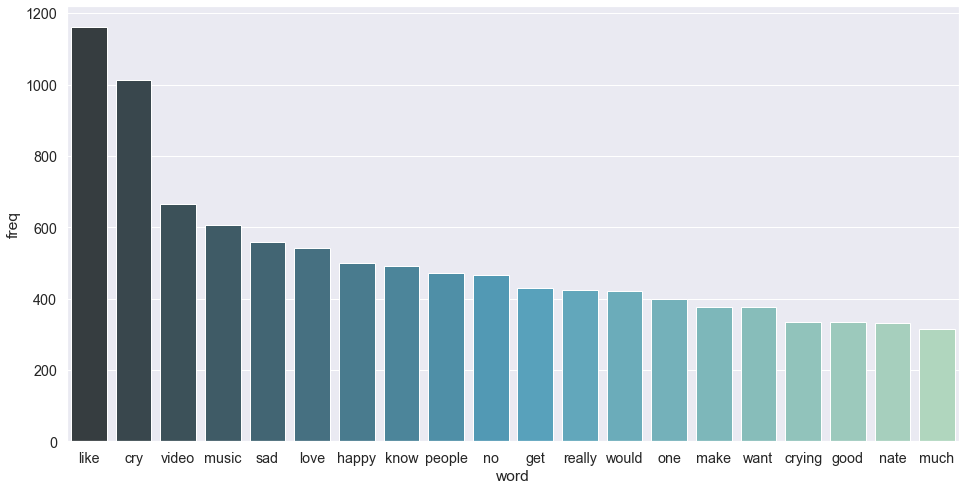

In [16]:
sr_clean = preprocess_df['clean_text']

count_vect = CountVectorizer()
bow = count_vect.fit_transform(sr_clean.values.astype('U'))
word_freq = dict(zip(count_vect.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(16, 8))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="GnBu_d", ax=ax)
plt.show();

In [17]:
preprocess_model = Pipeline(
    steps=[
        ('counting', Counting()),
        ('mkclean', MakeCleanText()),
        ('rmempty', FilterEmptyText())
    ]
)
X = preprocess_model.fit_transform(df)

In [18]:
y = X['emotion']
X.drop(columns=['emotion'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

X_train.head()

,text,emotion,emotion_label,count_words,count_capital,count_excl_quest,count_positive_emojis,count_negative_emojis,clean_text
9023,I dont know whats worse the fact that his name...,0,Neutral,17,0,0,0,0,know whats worse fact name zeus puka shell nec...
8107,I didnt cry but this was the cutest thing ever,3,Sad,10,0,0,0,0,cry cutest thing ever
10148,I tried doing that my girl left me.,3,Sad,8,0,0,0,0,tried girl left
10940,How do you not have 500 ML subscriber,3,Sad,8,1,0,0,0,ml subscriber
687,I enjoy your music. It makes me relax. Thank you.,1,Happy,10,0,0,0,0,enjoy music makes relax thank


### 2. Xây dựng model
1. Đầu tiên, nhóm ghép các csv đã annotate vào một df bằng lệnh `pd.concat(frames)`
2. Sau đó, nhóm split thành 4 tập `X_train, X_test, y_train, y_test`, train và test theo tỉ lệ 7/3, có shuffle.
3. Sử dụng tư tưởng `Bag Of Word` để xây dựng feature cho model, nhóm sử dụng `CountVectorize()` để xây dựng feature đó trên tập X_train. Lưu feature đó vào tập `X_train_counts`.
4. Vì không thể lấy số lượng chữ để train, vì nếu gặp văn bản có nhiều word so với văn bản có ít word sẽ có sự khác nhau rất lớn mặc dù về label sẽ không có sự khác nhau. Nên ta quy feature về tần suất xuất hiện của các word trong văn bản. Nhóm sử dụng `TfidfTransformer()` để transform từ số lượng word xuất hiện qua tần suất. Sau đó lưu vào ma trận tần suất `X_train_tfidf`.
5. Sau đó nhóm sử dụng ma trận tần suất `X_train_tfidf` để feed qua một lớp classifier để phân loại. Ở đây nhóm sử dụng `SGDClassifier` để phân loại.

In [19]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [20]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None):
    
    textcountscols = [
        'count_negative_emojis',
        'count_positive_emojis',
        'count_excl_quest',
        'count_capital',
        'count_words'
    ]
    
    # Tạo pipeline chuyển 'clean_text' sang BOW hay TFIDF
    cleanTextPipeline = Pipeline(
        steps=[
            ('cleantext', ColumnExtractor(cols='clean_text')), 
            ('vect', vect)
        ]
    )
    
    features = FeatureUnion(
        transformer_list=[
            ('textcounts', ColumnExtractor(cols=textcountscols)), 
            ('pipe', cleanTextPipeline)
        ],
        
        # Sử dụng tất cả CPUs
        n_jobs=-1
    )

    
    pipeline = Pipeline([
        ('features', features),
        ('clf', clf)
    ])
    
    # Kết hợp parameters_text (của BOW hay TTFIDF) và parameters_clf (hyper parameter của classifier)
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    # Best CV score = mean(cross-validated scored of best estimator)
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [21]:
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


parameters_logreg = {
    # Inverse of regularization strength; must be a positive float. Like in support vector machines, 
    # smaller values specify stronger regularization.
    'clf__C': (0.5, 1.0),
}

parameters_sgd = {
    'clf__alpha': (1e-3, 1e-4),
    'clf__loss': ('hinge', 'log')
}

In [22]:
mnb = MultinomialNB()
logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=100, penalty='l2')
sgd = SGDClassifier(max_iter=100, penalty='l2')

countvect = CountVectorizer()
tfidfvect = TfidfVectorizer()

In [23]:
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   35.8s finished


done in 36.736s

Best CV score: 0.617
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.616


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.59      0.56      0.58       668
           1       0.71      0.66      0.68       618
           2       0.53      0.52      0.53       498
           3       0.62      0.69      0.65       734

    accuracy                           0.62      2518
   macro avg       0.61      0.61      0.61      2518
weighted avg       0.62      0.62      0.62      2518



In [24]:
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.5, 1.0),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.3min finished
C:\Users\LAP11121-local\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


done in 143.080s

Best CV score: 0.610
Best parameters set:
	clf__C: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.620


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.53      0.68      0.60       668
           1       0.64      0.71      0.67       618
           2       0.64      0.43      0.52       498
           3       0.70      0.62      0.66       734

    accuracy                           0.62      2518
   macro avg       0.63      0.61      0.61      2518
weighted avg       0.63      0.62      0.62      2518



In [25]:
best_sgd_countvect = grid_vect(sgd, parameters_sgd, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.001, 0.0001),
 'clf__loss': ('hinge', 'log'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.2min finished


done in 72.832s

Best CV score: 0.620
Best parameters set:
	clf__alpha: 0.0001
	clf__loss: 'log'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.639


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       668
           1       0.69      0.68      0.68       618
           2       0.58      0.52      0.55       498
           3       0.75      0.63      0.68       734

    accuracy                           0.64      2518
   macro avg       0.64      0.63      0.63      2518
weighted avg       0.65      0.64      0.64      2518



In [26]:
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   27.8s finished


done in 28.907s

Best CV score: 0.605
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.601


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       668
           1       0.73      0.65      0.69       618
           2       0.54      0.44      0.48       498
           3       0.59      0.71      0.64       734

    accuracy                           0.60      2518
   macro avg       0.60      0.59      0.59      2518
weighted avg       0.60      0.60      0.60      2518



In [27]:
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.5, 1.0),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.6min finished
C:\Users\LAP11121-local\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


done in 155.453s

Best CV score: 0.585
Best parameters set:
	clf__C: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.591


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.44      0.79      0.57       668
           1       0.76      0.56      0.65       618
           2       0.66      0.36      0.47       498
           3       0.73      0.59      0.65       734

    accuracy                           0.59      2518
   macro avg       0.65      0.58      0.58      2518
weighted avg       0.65      0.59      0.59      2518



In [28]:
best_sgd_tfidf = grid_vect(sgd, parameters_sgd, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.001, 0.0001),
 'clf__loss': ('hinge', 'log'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.2min finished


done in 69.787s

Best CV score: 0.570
Best parameters set:
	clf__alpha: 0.001
	clf__loss: 'hinge'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.601


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       668
           1       0.79      0.56      0.66       618
           2       0.43      0.66      0.52       498
           3       0.69      0.64      0.67       734

    accuracy                           0.60      2518
   macro avg       0.62      0.60      0.60      2518
weighted avg       0.63      0.60      0.61      2518

